In [37]:
import os
import numpy as np
import pydicom
import cv2
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import VGG16

In [38]:
# Create a label mapping
label_mapping = {
    'Healthy': 0,
    'Hearniated_disk': 1,
    'Spinal_stenosis': 2,
    'Spondylosis': 3
}

In [39]:

# Load dataset
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        if label not in label_mapping:  # Check if label exists in the mapping
            print(f"Warning: Label '{label}' not found in label mapping. Skipping.")
            continue
        class_folder = os.path.join(folder, label)
        for filename in os.listdir(class_folder):
            if filename.endswith('.dcm'):
                # Read DICOM image
                dicom_file = pydicom.dcmread(os.path.join(class_folder, filename))
                # Convert to image
                img = dicom_file.pixel_array
                img = cv2.resize(img, (128, 128))  
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  
                images.append(img)
                # Map the label to an integer
                labels.append(label_mapping[label])  # Use the mapping here
    return np.array(images), np.array(labels)

# Load and preprocess data
images, labels = load_images_from_folder('Dataset')
images = images.astype('float32') / 255.0  # Normalize

In [40]:
# Convert labels to categorical
labels = keras.utils.to_categorical(labels, num_classes=len(label_mapping))  # Adjust num_classes based on your unique labels

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [41]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((75, 128, 128, 3), (19, 128, 128, 3), (75, 4), (19, 4))

In [42]:
# Build CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # Adjust channels as necessary
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_mapping), activation='softmax')  # Adjust based on your classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [43]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - accuracy: 0.2940 - loss: 2.0526 - val_accuracy: 0.7895 - val_loss: 1.0361
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.7851 - loss: 0.9904 - val_accuracy: 0.7368 - val_loss: 0.7511
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.5711 - loss: 0.9081 - val_accuracy: 0.9474 - val_loss: 0.5074
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.8403 - loss: 0.5465 - val_accuracy: 0.7895 - val_loss: 0.3565
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.8085 - loss: 0.3874 - val_accuracy: 0.8947 - val_loss: 0.2397
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.9271 - loss: 0.2995 - val_accuracy: 0.9474 - val_loss: 0.2399
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.9655 - loss: 0.2053 - val_accuracy: 0.7895 - val_loss: 0.2394
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.9081 - loss: 0.1673 - val_accuracy: 0.9474 - val_loss:

In [44]:
# Save the model
model.save('spine_mri_model.h5')

In [45]:
# Evaluate the model on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = np.argmax(y_val, axis=1)  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


In [46]:
# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=label_mapping.keys())


In [47]:
# Print classification report
print(report)

                 precision    recall  f1-score   support

        Healthy       0.80      1.00      0.89         4
Hearniated_disk       1.00      0.50      0.67         2
Spinal_stenosis       1.00      1.00      1.00         9
    Spondylosis       1.00      1.00      1.00         4

       accuracy                           0.95        19
      macro avg       0.95      0.88      0.89        19
   weighted avg       0.96      0.95      0.94        19



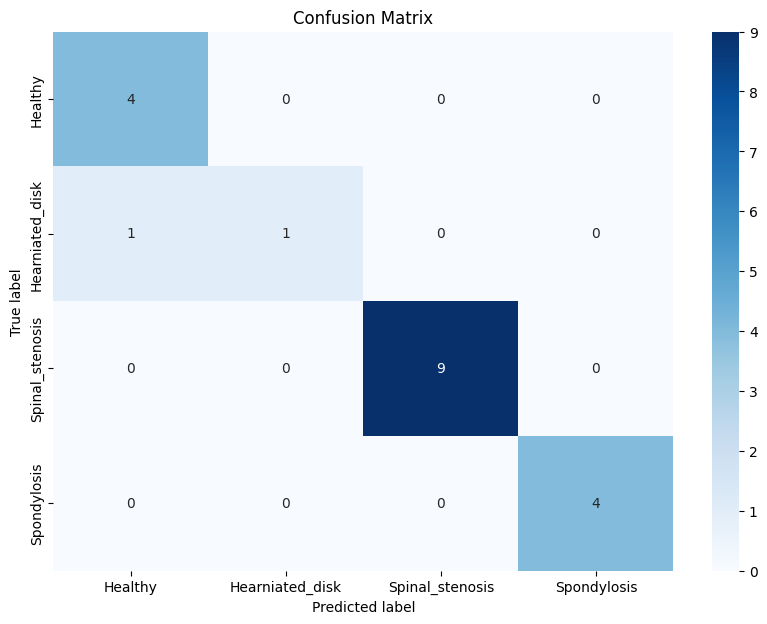

In [48]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


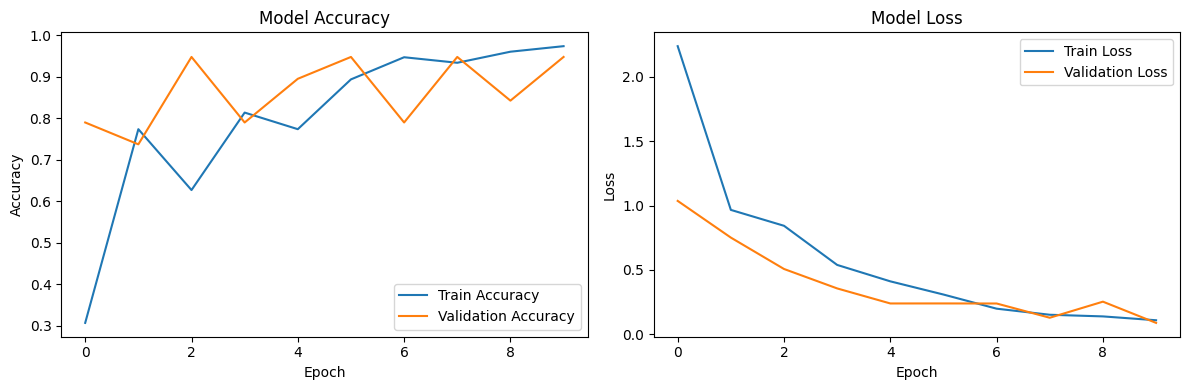

In [49]:
# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Mobilenet

In [50]:

# Use ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [51]:
# Build MobileNetV2 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))  

# Freeze the base model
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_mapping), activation='softmax')  
])


In [52]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32), 
                    validation_data=(X_val, y_val), 
                    epochs=10)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 980ms/step - accuracy: 0.5578 - loss: 1.0105 - val_accuracy: 0.6842 - val_loss: 0.6810
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.7472 - loss: 0.5686 - val_accuracy: 0.9474 - val_loss: 0.3307
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.6935 - loss: 0.6410 - val_accuracy: 0.8421 - val_loss: 0.2792
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.8263 - loss: 0.3614 - val_accuracy: 0.8421 - val_loss: 0.4141
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.7761 - loss: 0.4863 - val_accuracy: 0.8421 - val_loss: 0.3279
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 0.7920 - loss: 0.3388 - val_accuracy: 0.9474 - val_loss: 0.1603
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.9092 - loss: 0.2581 - val_accuracy: 1.0000 - val_loss: 0.1480
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.9104 - loss: 0.2299 - val_accuracy: 0.8947 - val_loss: 0.1930
Epo

In [53]:
# Save the model
model.save('spine_mri_mobilenet_model.h5')

In [54]:
# Evaluate the model on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_val, axis=1)  # Get true labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [55]:
# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=label_mapping.keys())

# Print classification report
print(report)

                 precision    recall  f1-score   support

        Healthy       1.00      1.00      1.00         4
Hearniated_disk       1.00      1.00      1.00         2
Spinal_stenosis       1.00      1.00      1.00         9
    Spondylosis       1.00      1.00      1.00         4

       accuracy                           1.00        19
      macro avg       1.00      1.00      1.00        19
   weighted avg       1.00      1.00      1.00        19



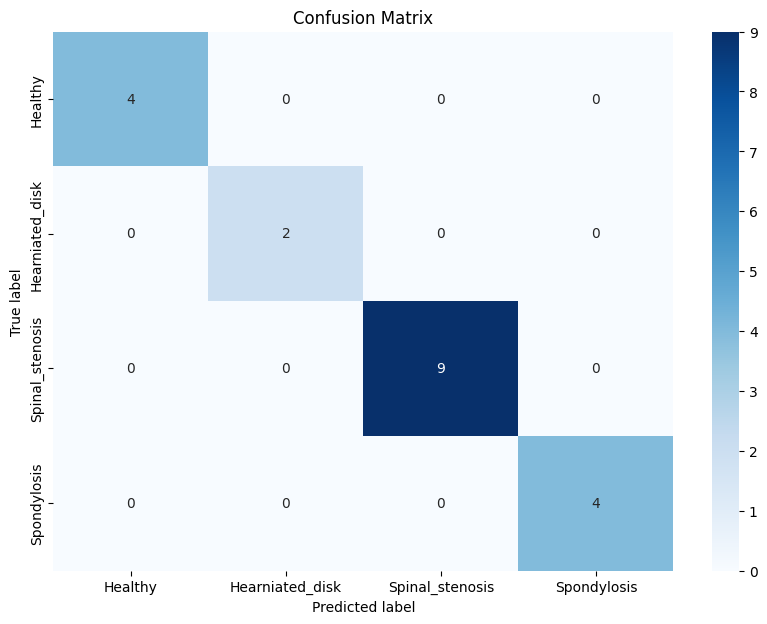

In [56]:



# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


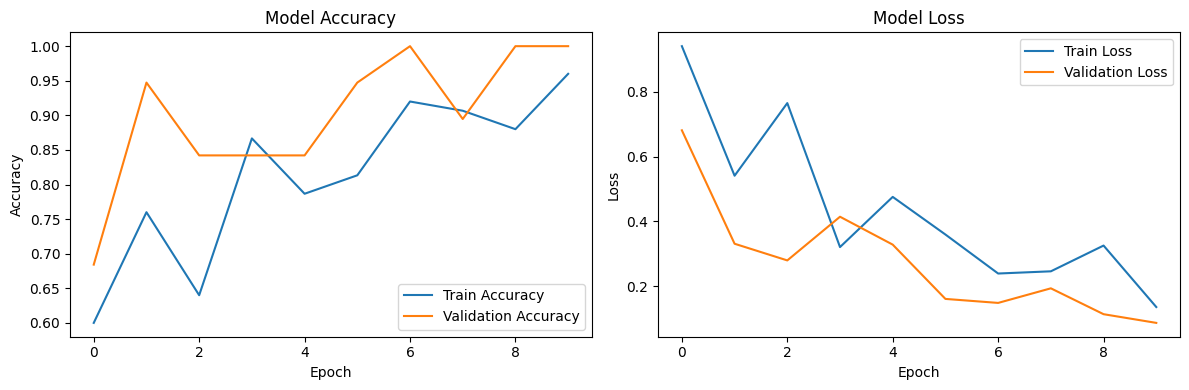

In [57]:
# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Densenet 

In [58]:
# Build DenseNet Model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))  

# Freeze the base model
base_model.trainable = False

# Create a new model with the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_mapping), activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32), 
                    validation_data=(X_val, y_val), 
                    epochs=10)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.1986 - loss: 2.6343 - val_accuracy: 0.5789 - val_loss: 0.8512
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6413 - loss: 1.0263 - val_accuracy: 0.6316 - val_loss: 0.8153
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7675 - loss: 0.6654 - val_accuracy: 0.7895 - val_loss: 0.5239
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7522 - loss: 0.6378 - val_accuracy: 0.7368 - val_loss: 0.3079
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6971 - loss: 0.6043 - val_accuracy: 0.8421 - val_loss: 0.2903
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7889 - loss: 0.3911 - val_accuracy: 0.7895 - val_loss: 0.3357
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8214 - loss: 0.3812 - val_accuracy: 0.8421 - val_loss: 0.2878
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8045 - loss: 0.3553 - val_accuracy: 0.9474 - val_loss: 0.2446
Epoch 9/10
3/3 ━━━━━━━━━━━

In [59]:
# Save the model
model.save('spine_mri_densenet_model.h5')


In [60]:
# Evaluate the model on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_val, axis=1)  # Get true labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


                 precision    recall  f1-score   support

        Healthy       0.00      0.00      0.00         4
Hearniated_disk       0.33      1.00      0.50         2
Spinal_stenosis       1.00      1.00      1.00         9
    Spondylosis       1.00      1.00      1.00         4

       accuracy                           0.79        19
      macro avg       0.58      0.75      0.62        19
   weighted avg       0.72      0.79      0.74        19



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

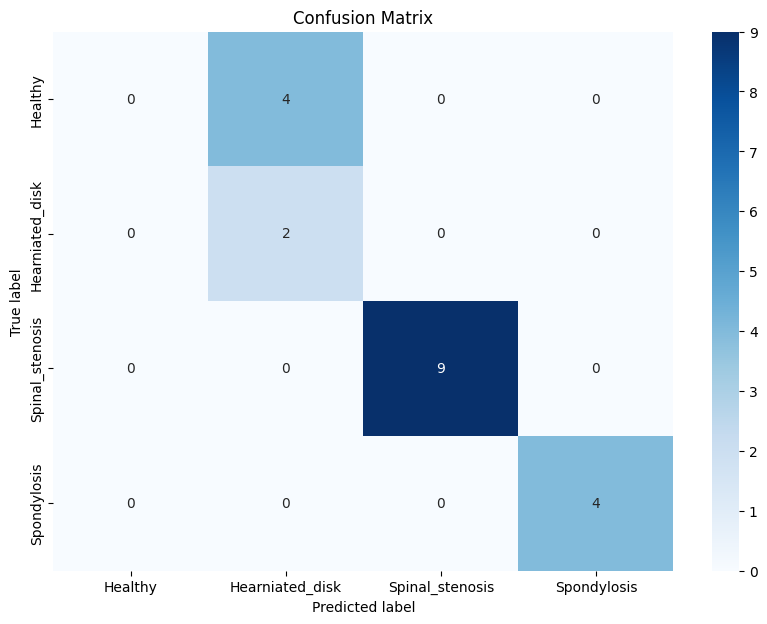

In [61]:
# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=label_mapping.keys())

# Print classification report
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

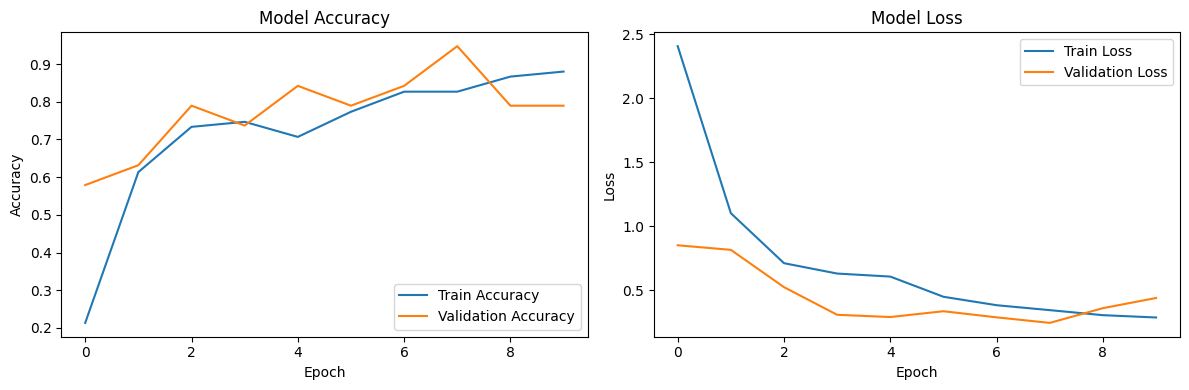

In [62]:
# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# VGG16

In [63]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

# Create the new model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_mapping), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [64]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32), 
                    validation_data=(X_val, y_val), 
                    epochs=10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1200 - loss: 1.7450 - val_accuracy: 0.5263 - val_loss: 1.1987
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4087 - loss: 1.3084 - val_accuracy: 0.5789 - val_loss: 1.0849
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6419 - loss: 1.1295 - val_accuracy: 0.6842 - val_loss: 0.9358
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.7314 - loss: 0.9505 - val_accuracy: 0.7895 - val_loss: 0.7947
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7469 - loss: 0.8939 - val_accuracy: 0.7895 - val_loss: 0.6755
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8576 - loss: 0.7037 - val_accuracy: 0.7895 - val_loss: 0.5945
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8414 - loss: 0.6673 - val_accuracy: 0.7895 - val_loss: 0.5116
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8615 - loss: 0.5898 - val_accuracy: 0.7895 - val_loss: 0.4597
Epoch 9/10
3/3 ━

In [65]:
# Save the model
model.save('spine_mri_vgg16_model.h5')


In [66]:
# Evaluate the model on validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.argmax(y_val, axis=1)  # Get true labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


                 precision    recall  f1-score   support

        Healthy       0.00      0.00      0.00         4
Hearniated_disk       0.33      1.00      0.50         2
Spinal_stenosis       1.00      1.00      1.00         9
    Spondylosis       1.00      1.00      1.00         4

       accuracy                           0.79        19
      macro avg       0.58      0.75      0.62        19
   weighted avg       0.72      0.79      0.74        19



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

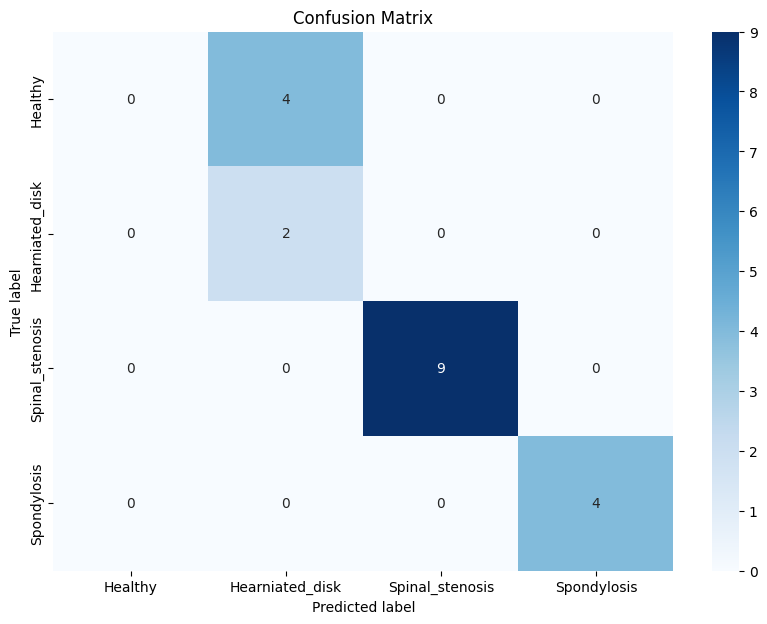

In [67]:
# Generate confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=label_mapping.keys())

# Print classification report
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

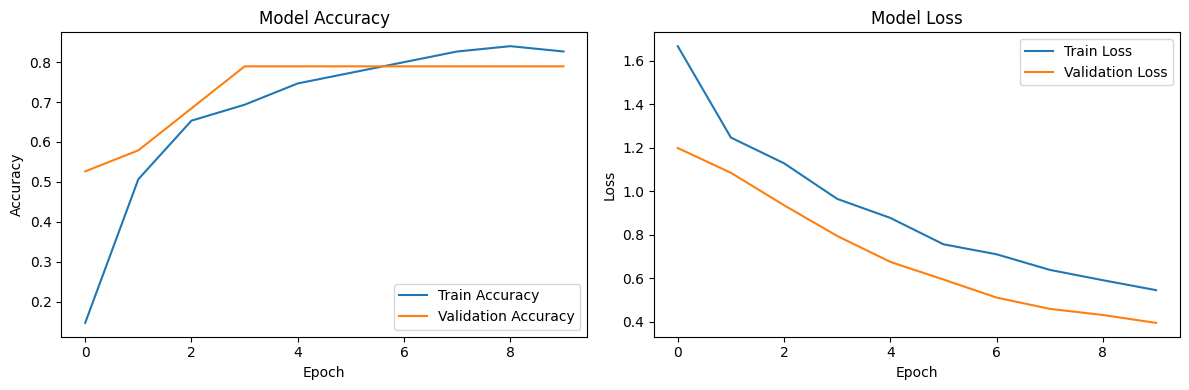

In [68]:
# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Hybrid Model (CNN+SVM)

In [ ]:
# Load dataset
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        if label not in label_mapping:  # Check if label exists in the mapping
            print(f"Warning: Label '{label}' not found in label mapping. Skipping.")
            continue
        class_folder = os.path.join(folder, label)
        for filename in os.listdir(class_folder):
            if filename.endswith('.dcm'):
                # Read DICOM image
                dicom_file = pydicom.dcmread(os.path.join(class_folder, filename))
                # Convert to image
                img = dicom_file.pixel_array
                img = cv2.resize(img, (128, 128))  # Resize for consistency
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to RGB
                images.append(img)
                # Map the label to an integer
                labels.append(label_mapping[label])  # Use the mapping here
    return np.array(images), np.array(labels)

In [ ]:
# Load and preprocess data
images, labels = load_images_from_folder('Dataset')
images = images.astype('float32') / 255.0  # Normalize

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:
# Build CNN Model for feature extraction
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_mapping), activation='softmax')  
])

# Compile the model using sparse_categorical_crossentropy
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - accuracy: 0.5040 - loss: 2.5207 - val_accuracy: 0.7368 - val_loss: 0.8831
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 390ms/step - accuracy: 0.6815 - loss: 0.7884 - val_accuracy: 0.7895 - val_loss: 0.5343
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step - accuracy: 0.8051 - loss: 0.5310 - val_accuracy: 0.7895 - val_loss: 0.2802
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - accuracy: 0.8157 - loss: 0.2776 - val_accuracy: 0.7895 - val_loss: 0.6905
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step - accuracy: 0.8485 - loss: 0.4117 - val_accuracy: 0.8947 - val_loss: 0.1655
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - accuracy: 0.8341 - loss: 0.1962 - val_accuracy: 0.8421 - val_loss: 0.1904
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step - accuracy: 0.9471 - loss: 0.1406 - val_accuracy: 0.8421 - val_loss: 0.1882
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step - accuracy: 0.9632 - loss: 0.1128 - val_accuracy: 1.0000 - val_loss: 0.1409
Epo

In [ ]:

# Extract features using the trained CNN
feature_extractor = models.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)

# Get the features for training and validation datasets
X_train_features = feature_extractor.predict(X_train)
X_val_features = feature_extractor.predict(X_val)


AttributeError: The layer sequential_9 has never been called and thus has no defined input.

In [ ]:
X_val_features

array([[3.5749624 , 1.9959291 , 0.29704463, ..., 7.3401246 , 0.        ,
        0.        ],
       [0.        , 0.9282011 , 0.        , ..., 5.2559285 , 0.        ,
        0.        ],
       [4.02363   , 4.050441  , 1.0752783 , ..., 9.277334  , 0.        ,
        0.        ],
       ...,
       [0.        , 1.4033499 , 0.        , ..., 4.940448  , 0.        ,
        0.        ],
       [0.        , 2.1273472 , 0.        , ..., 4.2214274 , 0.        ,
        0.        ],
       [3.194345  , 3.167971  , 0.        , ..., 7.165098  , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_val_features = scaler.transform(X_val_features)

In [ ]:
import joblib
cnn_model.save("feature_extractor.h5")


In [ ]:

joblib.dump(scaler,"scaler.pkl")

['scaler.pkl']

In [ ]:
# Train the SVM
svm_model = SVC(kernel='linear')  
svm_model.fit(X_train_features, y_train)

SVC(kernel='linear')

In [ ]:
# Evaluate the SVM
y_pred = svm_model.predict(X_val_features)

In [ ]:
# Generate confusion matrix and classification report
cm = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=label_mapping.keys())

# Print classification report
print(report)

                 precision    recall  f1-score   support

        Healthy       1.00      0.75      0.86         4
Hearniated_disk       0.80      1.00      0.89         4
Spinal_stenosis       1.00      1.00      1.00         8
    Spondylosis       1.00      1.00      1.00         3

       accuracy                           0.95        19
      macro avg       0.95      0.94      0.94        19
   weighted avg       0.96      0.95      0.95        19



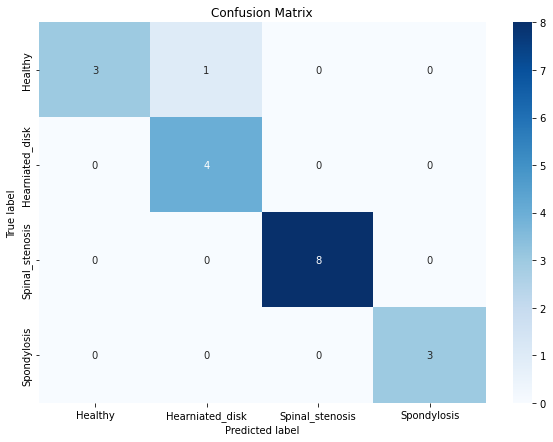

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
cnn_model.save('cnn_feature_extractor.h5')  # Save CNN model
feature_extractor.save('cnn_model.h5')      # Save feature extractor model
joblib.dump(scaler, 'scaler.joblib')         # Save scaler
joblib.dump(svm_model, 'svm_model.joblib')   # Save SVM model

['svm_model.joblib']

# Single image prediction(testing)

In [ ]:
import numpy as np
import pydicom
import cv2
from tensorflow import keras
import joblib

# Load the saved models
cnn_model = keras.models.load_model('cnn_feature_extractor.h5')  
feature_extractor = keras.models.load_model('cnn_model.h5')       
scaler = joblib.load('scaler.joblib')                             
svm_model = joblib.load('svm_model.joblib')                   

# Create a label mapping
label_mapping = {
    0: 'Healthy',
    1: 'Herniated_disk',
    2: 'Spinal_stenosis',
    3: 'Spondylosis'
}

# Function to preprocess a single DICOM image for prediction
def preprocess_image(file_path):
    # Read the DICOM file
    dicom_file = pydicom.dcmread(file_path)
    # Convert to image
    img = dicom_file.pixel_array
    img = cv2.resize(img, (128, 128))  # Resize for consistency
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to RGB
    img = img.astype('float32') / 255.0  # Normalize
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Function to make predictions using all models
def predict_single_input(file_path):
    # Preprocess the image
    input_image = preprocess_image(file_path)

    # Extract features using the CNN
    features = feature_extractor.predict(input_image)

    # Scale the features
    scaled_features = scaler.transform(features)

    # Make predictions using SVM
    svm_prediction = svm_model.predict(scaled_features)

    # Make predictions using CNN
    cnn_prediction = cnn_model.predict(input_image)

    # Get the predicted class
    svm_class = svm_prediction[0]
    cnn_class = np.argmax(cnn_prediction, axis=1)[0]  # Get class index for CNN

    # Map the predicted classes to their corresponding labels
    svm_label = label_mapping[svm_class]
    cnn_label = label_mapping[cnn_class]

    return svm_label, cnn_label

# Example usage
file_path = r'Dataset\Healthy\IM000005.dcm'  # Replace with the path to your DICOM file
svm_label, cnn_label = predict_single_input(file_path)

# Output the results
print(f'SVM predicted class: {svm_label}')
print(f'CNN predicted class: {cnn_label}')


SVM predicted class: Healthy
CNN predicted class: Healthy
